In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
             "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
             "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
             "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
             "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
             "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
             "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack", "last_flag"]

train_df = pd.read_csv("data/Train.csv", names=col_names)
test_df = pd.read_csv("data/Test.csv", names=col_names)

# Binary encode target
train_df['target'] = train_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)
test_df['target'] = test_df['attack'].apply(lambda x: 0 if x == 'normal' else 1)

# Label encode categoricals
for col in ['protocol_type', 'service', 'flag']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Drop unused
train_df.drop(['attack', 'last_flag'], axis=1, inplace=True)
test_df.drop(['attack', 'last_flag'], axis=1, inplace=True)

# Extract features
X_train_full = train_df.drop('target', axis=1)
y_train_full = train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target'].values

# Train on normal only
X_train_norm = X_train_full[y_train_full == 0]

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_norm)
X_test_scaled = scaler.transform(X_test)


In [2]:
from sklearn.ensemble import IsolationForest

# Fit model
iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso.fit(X_train_scaled)

IsolationForest(contamination=0.05, random_state=42)

In [3]:
# Decision function returns anomaly scores (lower means more anomalous)
scores_test = iso.decision_function(X_test_scaled)

# Predict labels: -1 = anomaly, 1 = normal
y_pred_raw = iso.predict(X_test_scaled)
y_pred = (y_pred_raw == -1).astype(int)  # Convert -1 to 1 (anomaly)

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ROC AUC
roc_auc = roc_auc_score(y_test, -scores_test)  # Invert score (lower = more anomaly)
print(f"ROC AUC Score: {roc_auc:.4f}")

Confusion Matrix:
[[9496  215]
 [4541 8292]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6765    0.9779    0.7997      9711
           1     0.9747    0.6461    0.7771     12833

    accuracy                         0.7890     22544
   macro avg     0.8256    0.8120    0.7884     22544
weighted avg     0.8463    0.7890    0.7869     22544

ROC AUC Score: 0.9397


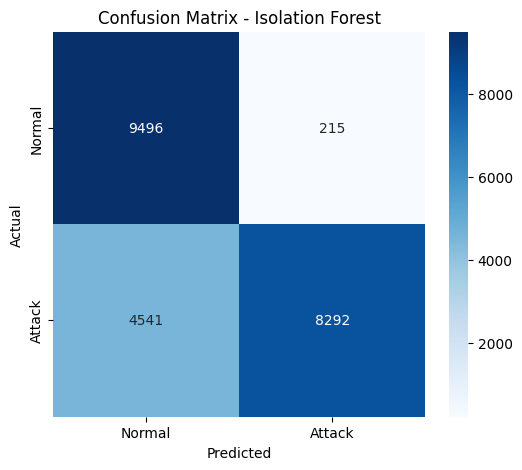

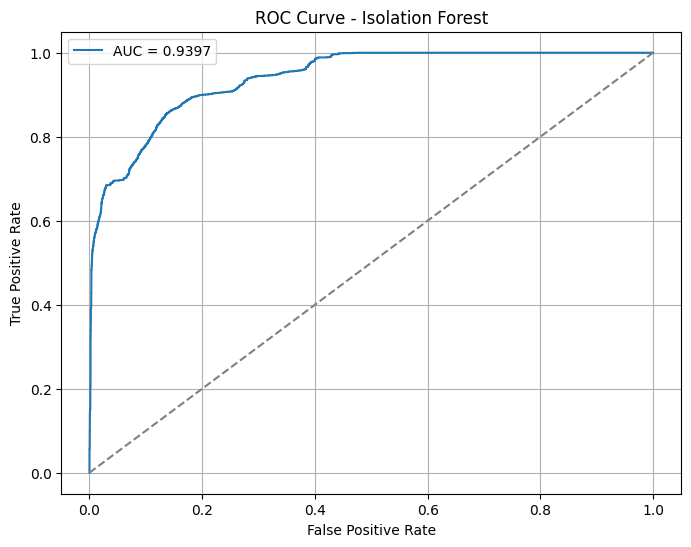

In [5]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Isolation Forest")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, -scores_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest")
plt.legend()
plt.grid()
plt.show()